<h1>Construir tablero de cohortes y Ltv con filtro por categoría</h1>

El proyecto consiste en usar zoho analytics para hacer calculos y transformación de datos con el fin obtener los siguientes datos
1. Analisis de cohortes con filtro por categoría (habiendo 8 categorías o tipos de clientes)
2. Calcluar el promedio de deserción por categoría de cliente
3. Calcular el LTV usando el dato de la columna revenue y calculando la tasa de retención segun el analisis de cohortes


<h1> Procedimientos</h1>

1. Preparar el entorno de desarrollo en el cuaderno de Jupiter para Google Colab
2. Importar bibliotecas de los métodos a utilizar
3. Carga de dataset en DataFrames
4. Análisis Exploratorio de Datos EDA
    - Cantidad de filas y variables
    - Vista aleatoria de cinco filas
    - Nombres de las variables
    - Tipos de las variables
    - Filas duplicadas
    - Variables con valores faltantes
    - Variables con valores atípicos (outliers) ó valores extremos
5. Preprocesamiento:
    - Seleccionar variables de interés (Feactures)
    - Tratamiento de variables con valores faltantes
    - Tratamiento de datos extremos y datos atípicos
6. Transformaciones
    - Convertir formato de decimales
    - Convertir formato de fecha
7. Construir DataFrame cohortes_df
8. Construir DataFrame desercion_df
9. Construir DataFrame metricas_df

### **1. Preparar el entorno de desarrollo en el cuaderno de Jupiter para Google Colab**

Agregar aqui el código

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install -r "/content/drive/MyDrive/Colab Notebooks/project_name/requirements.txt"

In [2]:
# How can I suppresed Python warnings in Jupyter Notebook
# Why not just set n_init=10 explicitly and retain the same value as the default and get rid of those warnings?
import warnings
warnings.filterwarnings('ignore')

### **2. Importar bibliotecas de los métodos a utilizar**

Agregar aqui el código

In [20]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
#pip install missingno
import missingno as msno
import matplotlib.pyplot as plt

### **3. Carga de dataset en DataFrames**

Agregar aqui el código

In [52]:
path= '/content/drive/MyDrive/Colab Notebooks/240315-1_machine_learning_analisis_ventas_cohortes/datasets/Analisis.csv'
ventas_df = pd.read_csv(path,sep=';')

### **4. Análisis Exploratorio de Datos EDA**

**Cantidad de filas y variables**
    

In [15]:
print("Numero de filas ",ventas_df.shape[0])
print("Numero de campos ",ventas_df.shape[1])

Numero de filas  79322
Numero de campos  10


**Vista aleatoria de cinco filas**

In [53]:
ventas_df.sample(5)

,#,DOCUMENTO,VENDEDOR,CODCLIENTE,CATEGORIA,FECHA,GRUPO,UTILIDAD,TOTAL,U_Sub_Familia
42638,42639,1000033827,Mónica Valenci,C00688,Contratista A/C,21/11/2023,Cobre,"2,55","5,68",CONEXIONES
68284,68285,17160,Leydis Pitty,C00141,Contratista A/C,30/05/2022,Local,12,48,CABLES
75138,75139,1000019981,Jesus Atencio,CL00475,Comercio Retail,06/09/2022,PEX,"23,88","64,5",CONEXIONES
14978,14979,1000022373,Leydis Pitty,C02390,Exterior,02/12/2022,Parte Eléctric,"0,54","1,78",CAPACITOR MARCHA
70,71,17969,Ruben Bravo,C02370,Cliente Final,29/06/2022,Ventilació,"48,82","139,44",DUCTO FLEXIBLE


Notamos valores negativos en las variables UTILIDAD y TOTAL

**Nombres y Tipos de las variables**

In [59]:
ventas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79322 entries, 0 to 79321
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   #              79322 non-null  int64  
 1   DOCUMENTO      79322 non-null  int64  
 2   VENDEDOR       79322 non-null  object 
 3   CODCLIENTE     79322 non-null  object 
 4   CATEGORIA      79322 non-null  object 
 5   FECHA          79322 non-null  object 
 6   GRUPO          79260 non-null  object 
 7   UTILIDAD       79322 non-null  float64
 8   TOTAL          79322 non-null  float64
 9   U_Sub_Familia  70983 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 6.1+ MB


**Observación:** las variables UTILIDAD y TOTAL no son de tipo numéricas continuas (punto flotante) como debió ser, esto es debido a que el caracter de separación decimal es la coma y Pandas interpretó estos campos de tipo string

In [57]:
#Para poder continuar con el análisis exploratorio debemos sustituir la  coma decimal por punto decimal en las variables con valores numéricos
ventas_df["UTILIDAD"].replace(to_replace=',', value='.', regex=True,inplace=True)
ventas_df["TOTAL"].replace(to_replace=',', value='.', regex=True,inplace=True)

0          18.2
1         14.05
2         15.39
3        117.04
4         14.82
          ...  
79317     -0.36
79318    -626.1
79319      -8.7
79320    -19.26
79321    -31.03
Name: TOTAL, Length: 79322, dtype: object

In [58]:
# Ahora se debe convertir los campos UTILIDAD y TOTAL de tipo string  a tipo punto flotante
ventas_df["UTILIDAD"] = ventas_df["UTILIDAD"].astype(float)
ventas_df["TOTAL"] = ventas_df["TOTAL"].astype(float)

 Otras dos formas de remplazar una cadena de caracteres en campos de un dataframe:
- ventas_df["UTILIDAD"] = ventas_df["UTILIDAD"].apply(lambda x: x.replace(",","."))

- ventas_df.UTILIDAD.str.replace(',', ';')

Tres formas de convertir un string en entero:
- df["dataframe_column"] = df["dataframe_column"].astype(int)

- df["dataframe_column"] = df["dataframe_column"].apply(int)

- df["dataframe_column"] = df["dataframe_column"].map(int)

**Filas duplicadas**

In [60]:
ventas_df[ventas_df.duplicated()]

,#,DOCUMENTO,VENDEDOR,CODCLIENTE,CATEGORIA,FECHA,GRUPO,UTILIDAD,TOTAL,U_Sub_Familia


Observación: No hay registros duplicados

**Variables con valores faltantes**

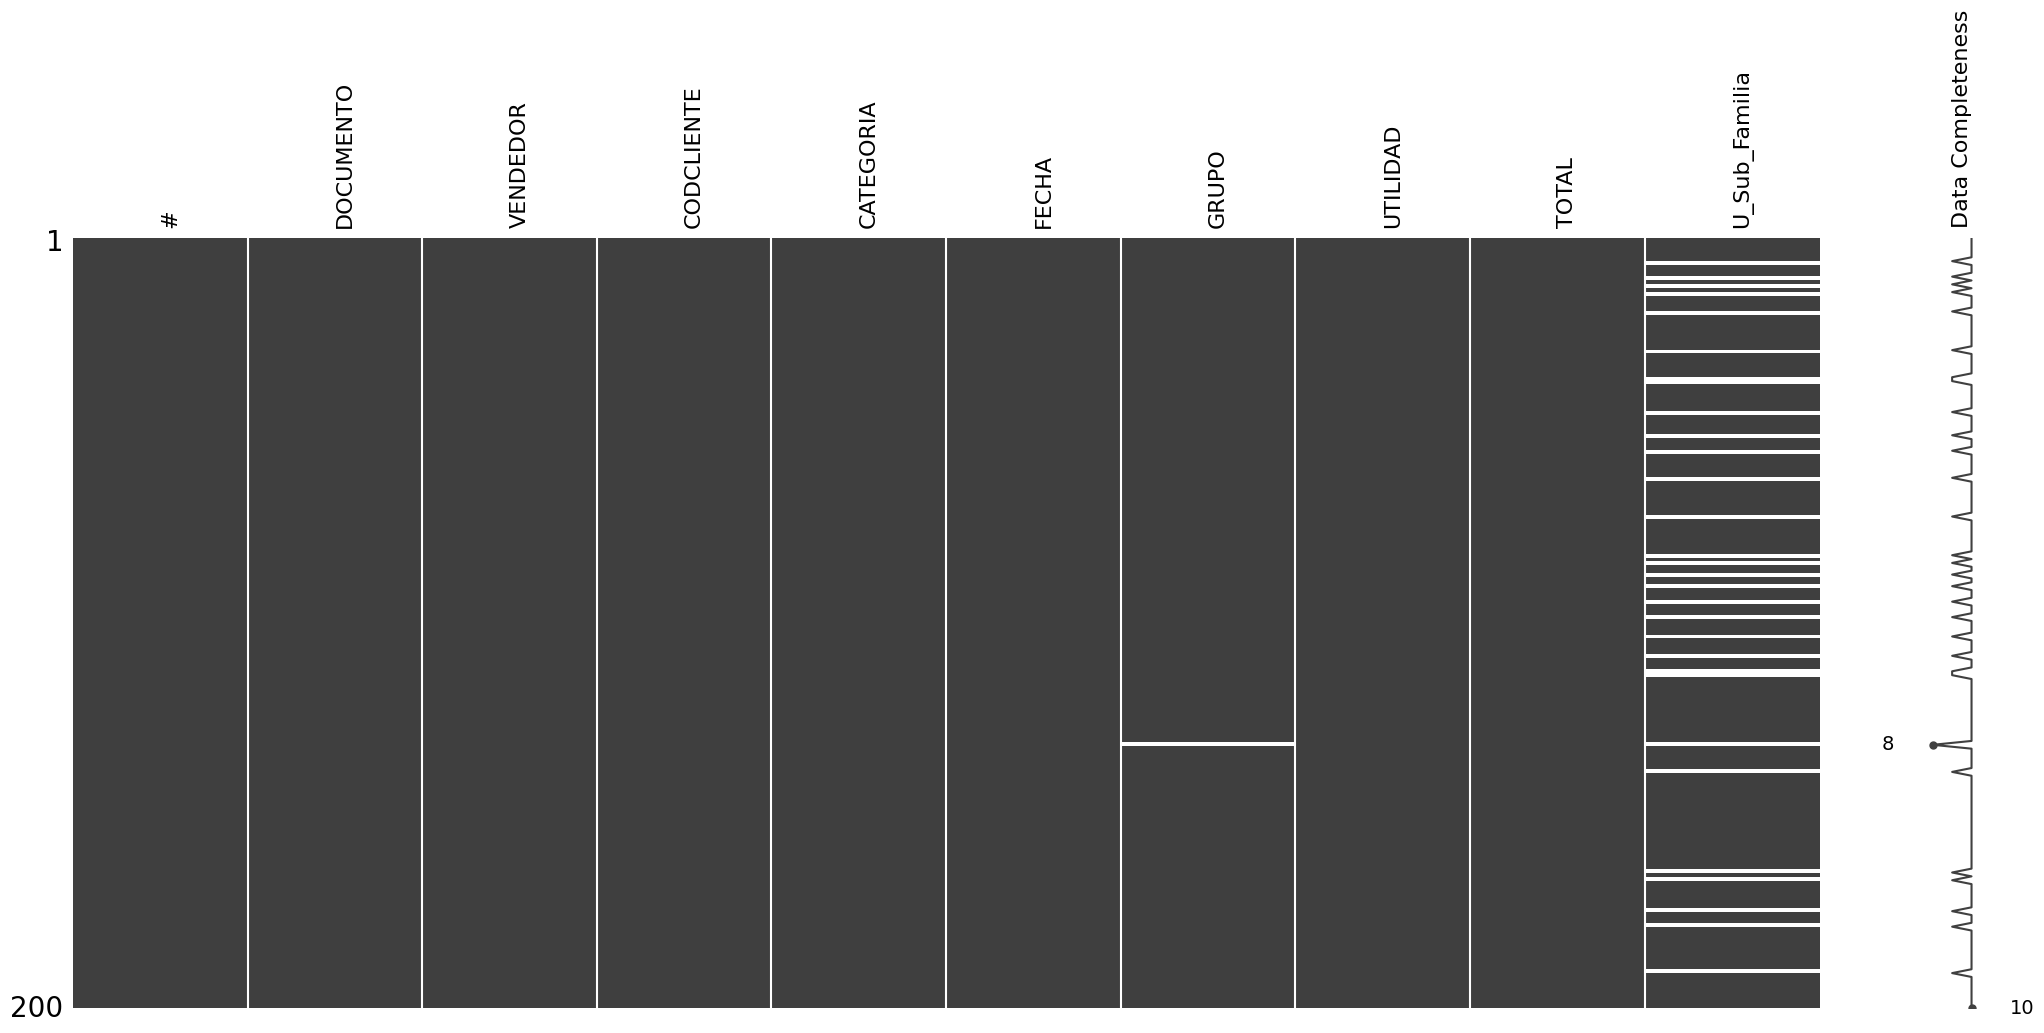

In [61]:
# Tomamos 200 muestras al azar de nuestra población
msno.matrix(ventas_df.sample(200), labels = True, label_rotation = 90)
plt.show()

Observación: Solo el campo U_Sub_Familia presenta valores faltantes

In [29]:
#Analizamos la columna U_Sub_Familia que es la que presenta mas datos nulos
print('Porcentaje de valores faltantes de la variable U_Sub_Familia:', round((ventas_df.U_Sub_Familia.isnull().sum()/len(ventas_df)) * 100,2), '%')

Porcentaje de valores faltantes de la variable U_Sub_Familia: 10.51 %


**Observación**: Para este estudio la variable **U_Sub_Familia** y la variable **GRUPO** no son relevantes así que se eliminarán del dataset mas adelante

**Variables con valores atípicos (outliers) ó valores extremos**

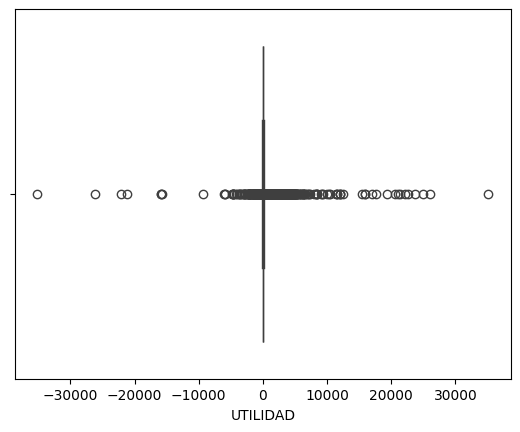

In [62]:
#Campos con valores atípicos:
sns.boxplot(x = 'UTILIDAD',  data= ventas_df )
plt.show()

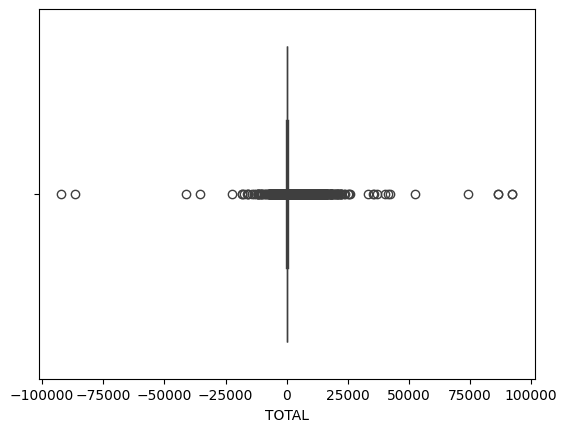

In [63]:
#Campos con valores atípicos:
sns.boxplot(x = 'TOTAL',  data= ventas_df )
plt.show()

**Observación:** La variables UTILIDAD y TOTAL presentan valores negativos los cuales son atípicos para cantidades monetarias, sin embargo puede tener significado en el caso de representar transacciones de credito o debito. Por ahora solo eliminaremos esos valores del dataFrame para que no afecte las medidas de tendencias centrales.

In [77]:
# Pero antes verifiquemos que tantos valores atípicos hay en dichos campos:
atipicos_utilidad = (ventas_df['UTILIDAD'] < 0).sum()
porcentaje_utilidad = round((atipicos_utilidad / len(ventas_df))*100, 2)
atipicos_total = (ventas_df['UTILIDAD'] < 0).sum()
porcentaje_total = round((atipicos_total / len(ventas_df))*100,2)
print("Total de valores atípicos en el campo UTILIDAD: {} ({}% del total)".format(atipicos_utilidad,porcentaje_utilidad))
print("Total de valores atípicos en el campo TOTAL: {} ({}% del total)".format(atipicos_total,porcentaje_total))

Total de valores atípicos en el campo UTILIDAD: 3875 (4.89% del total)
Total de valores atípicos en el campo TOTAL: 3875 (4.89% del total)


### **5. Preprocesamiento**

**Seleccionar variables significativas (Feactures)**

In [86]:
ventas_interes_df = ventas_df[['CODCLIENTE','CATEGORIA', 'FECHA', 'UTILIDAD', 'TOTAL']]

**Tratamiento de variables con valores faltantes**

Se eliminaron las variables (columnas) con valores faltantes en el paso anterior

**Tratamiento de datos extremos y datos atípicos**

In [87]:
ventas_interes_df.query("UTILIDAD < 0")

,CODCLIENTE,CATEGORIA,FECHA,UTILIDAD,TOTAL
505,C01052,Cliente Final,05/01/2022,-73.51,250.84
892,CL00057,Agrícol,09/05/2022,-23.51,270.38
1981,C00493,Contratista Refrigeració,12/12/2022,-21.72,0.00
2053,C00141,Contratista A/C,30/12/2022,-26.00,0.00
2251,CL01531,Cliente Final,24/07/2023,-12.23,0.00
...,...,...,...,...,...
79255,CL01025,Técnico Independient,01/03/2024,-21.66,-61.77
79256,CL01025,Técnico Independient,01/03/2024,-17.81,-44.52
79257,CL01025,Técnico Independient,01/03/2024,-2.11,-5.57
79258,CL01025,Técnico Independient,01/03/2024,-5.97,-11.60


In [91]:
ventas_clientes_df = ventas_interes_df.query("UTILIDAD > 0")
ventas_clientes_df = ventas_interes_df.query("TOTAL > 0")
ventas_clientes_df

,CODCLIENTE,CATEGORIA,FECHA,UTILIDAD,TOTAL
0,C01292,Cliente Final,21/06/2022,8.20,18.20
1,C01292,Cliente Final,21/06/2022,5.62,14.05
2,C01292,Cliente Final,21/06/2022,5.39,15.39
3,C01292,Cliente Final,21/06/2022,40.98,117.04
4,C01039,Cliente Final,21/06/2022,6.67,14.82
...,...,...,...,...,...
75676,CL00194,Contratista A/C,20/06/2022,26.35,105.39
75677,C00540,Contratista A/C,21/06/2022,4.16,10.40
75678,C00540,Contratista A/C,21/06/2022,0.91,2.28
75679,C00540,Contratista A/C,21/06/2022,3.45,9.86


### **6. Transformaciónes**

**Convertir formato de decimales**

**Convertir formato de fecha**

### **7. Construir DataFrame cohortes_df**

**Convertir formato de decimales**

### **8. Construir DataFrame desercion_df**

**Convertir formato de decimales**

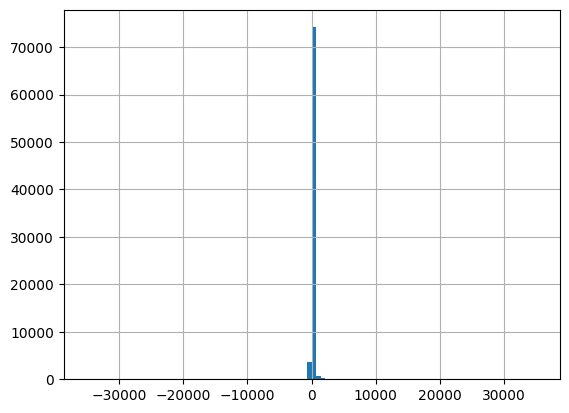

In [81]:
ventas_df.UTILIDAD.hist(bins = 100);

**Convertir formato de fecha**

### **9. Construir DataFrame metricas_df**

**Convertir formato de decimales**

**Convertir formato de fecha**